### important notice: On my side, I can run the three algorithms one by one because I tried to run them in one time but there may occur errors shows that server time out with some eceptions. BUT I run one by one, it works perfectly. So if you have the same problem, you can run them one by one. This doesn't means the code isn't work properly. 

# Import the data

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('is722_it4').getOrCreate()


Read the two datasets and append them together. Since the split ratio is not siutable. The ratio of training and testing I choose is 80% - 20% which is according to Pareto principle. And the split will perform after clean the data.

In [2]:
# Read two datasets and assign to df1 and df2.
df1 = spark.read.csv('Datasets/adult.data',header=True,inferSchema=True, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True)
df2 = spark.read.csv('Datasets/adult.test',header=True,inferSchema=True, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True)

# Append df2 to df1 to form a new dataset
df = df1.union(df2)

# View the data

In [3]:
df.show()

+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+---------------+
|age|       workclass|fnlwgt|   education|education-num|      marital-status|       occupation| relationship|              race|   sex|capital-gain|capital-loss|hours-per-week|native-country|income-classify|
+---+----------------+------+------------+-------------+--------------------+-----------------+-------------+------------------+------+------------+------------+--------------+--------------+---------------+
| 39|       State-gov| 77516|   Bachelors|           13|       Never-married|     Adm-clerical|Not-in-family|             White|  Male|        2174|           0|            40| United-States|          <=50K|
| 50|Self-emp-not-inc| 83311|   Bachelors|           13|  Married-civ-spouse|  Exec-managerial|      Husband|             White|  Male|           0|           0|       

#### Print out the schema of the data and number of instances and columns

In [4]:
df.printSchema()
print('Number of instances: ' + str(df.count()))
print('Number of columns: ' + str(len(df.columns)))

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: integer (nullable = true)
 |-- education: string (nullable = true)
 |-- education-num: integer (nullable = true)
 |-- marital-status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital-gain: integer (nullable = true)
 |-- capital-loss: integer (nullable = true)
 |-- hours-per-week: integer (nullable = true)
 |-- native-country: string (nullable = true)
 |-- income-classify: string (nullable = true)

Number of instances: 48842
Number of columns: 15


#### shows the statistics of continous data

In [5]:

df.select('age', 'fnlwgt', 'capital-gain', 'capital-loss').describe().show()

+-------+------------------+------------------+------------------+-----------------+
|summary|               age|            fnlwgt|      capital-gain|     capital-loss|
+-------+------------------+------------------+------------------+-----------------+
|  count|             48842|             48842|             48842|            48842|
|   mean| 38.64358543876172|189664.13459727284|1079.0676262233324|87.50231358257237|
| stddev|13.710509934443563|105604.02542315733| 7452.019057655401|403.0045521243599|
|    min|                17|             12285|                 0|                0|
|    max|                90|           1490400|             99999|             4356|
+-------+------------------+------------------+------------------+-----------------+



#### shows the distritubtion of income and edcuation

In [6]:
df.groupBy('income-classify').count().show()
df.groupBy('education').count().show()

+---------------+-----+
|income-classify|count|
+---------------+-----+
|         <=50K.|12435|
|          <=50K|24720|
|           >50K| 7841|
|          >50K.| 3846|
+---------------+-----+

+------------+-----+
|   education|count|
+------------+-----+
|     Masters| 2657|
|        10th| 1389|
|     5th-6th|  509|
|  Assoc-acdm| 1601|
|   Assoc-voc| 2061|
|     7th-8th|  955|
|         9th|  756|
|     HS-grad|15784|
|   Bachelors| 8025|
|        11th| 1812|
|     1st-4th|  247|
|   Preschool|   83|
|        12th|  657|
|   Doctorate|  594|
|Some-college|10878|
| Prof-school|  834|
+------------+-----+



#### delete the "." to make sure there are only two classes rather than four

In [7]:
from pyspark.sql.functions import *
df = df.withColumn('income-classify', regexp_replace('income-classify', '<=50K.', '<=50K'))
df = df.withColumn('income-classify', regexp_replace('income-classify', '>50K.', '>50K'))
df.groupBy('income-classify').count().show()

+---------------+-----+
|income-classify|count|
+---------------+-----+
|          <=50K|37155|
|           >50K|11687|
+---------------+-----+



#### show more details of income based on those continous featrues and format in a formaly way

In [8]:
from pyspark.sql.functions import format_number, col

df_groupBy_income = df.groupBy('income-classify').mean()
df_groupBy_income.show()



+---------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|income-classify|          avg(age)|       avg(fnlwgt)|avg(education-num)| avg(capital-gain)| avg(capital-loss)|avg(hours-per-week)|
+---------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|          <=50K| 36.87218409366169|190039.56552280986| 9.598492800430629| 147.0103081684834|54.151931099448255|  38.84004844570045|
|           >50K|44.275177547702576| 188470.5745700351|11.602806537178061|4042.2394968768717|193.52896380593822|  45.45289638059382|
+---------------+------------------+------------------+------------------+------------------+------------------+-------------------+



In [9]:
df_groupBy_income = df_groupBy_income.select('income-classify',
                            format_number('avg(age)', 2),
                            format_number('avg(fnlwgt)', 2),
                            format_number('avg(education-num)', 2),
                            format_number('avg(capital-gain)', 2),
                            format_number('avg(capital-loss)', 2))

df_groupBy_income = df_groupBy_income.select(
                            col('income-classify'),
                            col('format_number(avg(age), 2)').alias('Average Age'),
                            col('format_number(avg(fnlwgt), 2)').alias('Average fnlwgt'),
                            col('format_number(avg(education-num), 2)').alias('Average education-num'),
                            col('format_number(avg(capital-gain), 2)').alias('Average capital-gain'),
                            col('format_number(avg(capital-loss), 2)').alias('Average capital-loss'))

df_groupBy_income.show()


+---------------+-----------+--------------+---------------------+--------------------+--------------------+
|income-classify|Average Age|Average fnlwgt|Average education-num|Average capital-gain|Average capital-loss|
+---------------+-----------+--------------+---------------------+--------------------+--------------------+
|          <=50K|      36.87|    190,039.57|                 9.60|              147.01|               54.15|
|           >50K|      44.28|    188,470.57|                11.60|            4,042.24|              193.53|
+---------------+-----------+--------------+---------------------+--------------------+--------------------+



#### change the data frame into Pandas data frame to visualized data easily and nicely

In [10]:
# change the RDD DataFrame into pandas DataFrame for more data exploration
import pandas as pd
import matplotlib.pyplot as plt
pdf = df.toPandas()

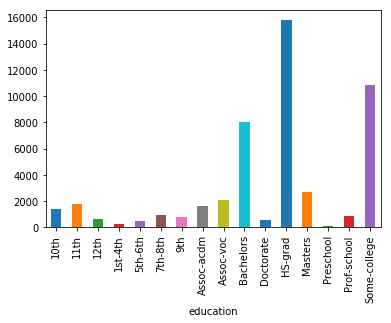

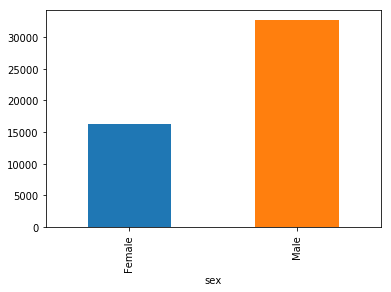

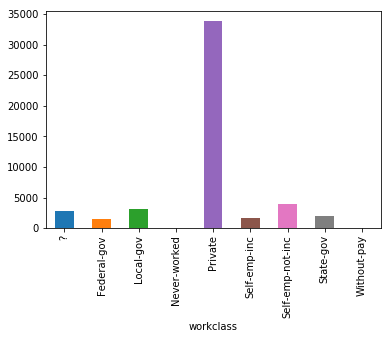

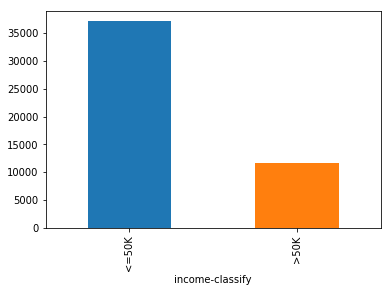

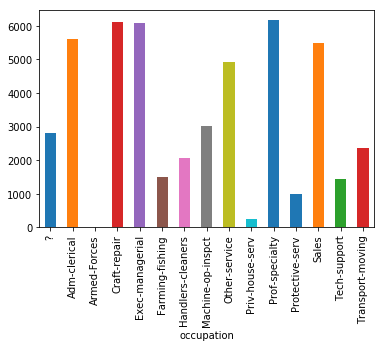

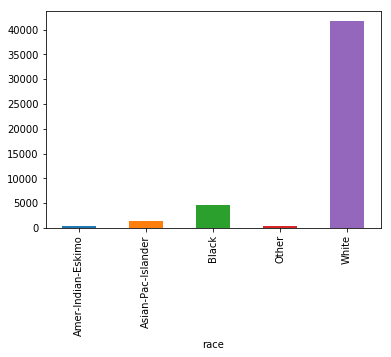

In [11]:
# plot the distribution of education, sex, workclass, income-classify, occupation and race
plt.figure()
pdf.groupby(['education']).size().plot(kind='bar')

plt.figure()
pdf.groupby(['sex']).size().plot(kind='bar')

plt.figure()
pdf.groupby(['workclass']).size().plot(kind='bar')

plt.figure()
pdf.groupby(['income-classify']).size().plot(kind='bar')

plt.figure()
pdf.groupby(['occupation']).size().plot(kind='bar')

plt.figure()
pdf.groupby(['race']).size().plot(kind='bar')

<Figure size 432x288 with 0 Axes>

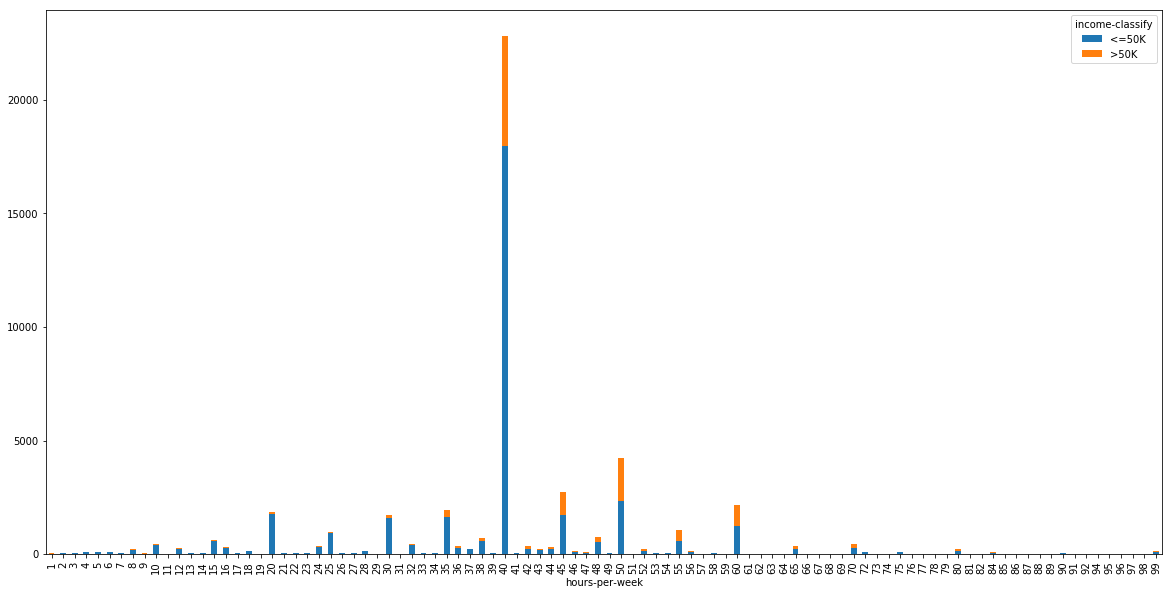

In [12]:
plt.figure()
pdf.groupby(['hours-per-week', 'income-classify']).size().unstack().plot(kind='bar', figsize=(20, 10), stacked = True)

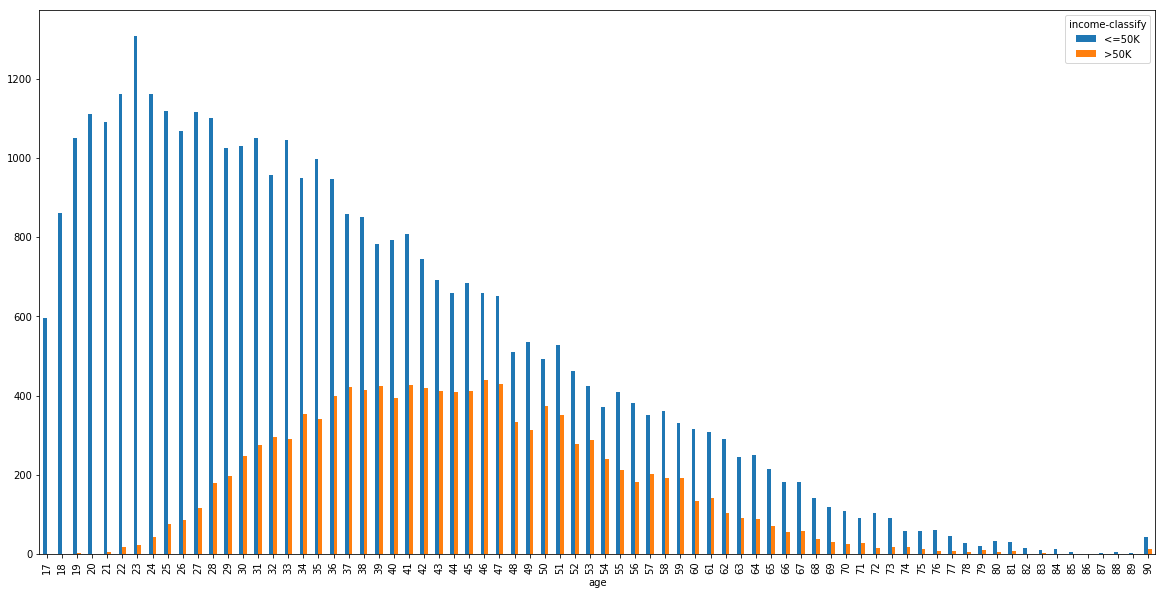

In [13]:
# age vs income
pdf.groupby(['age', 'income-classify']).size().unstack().plot(kind='bar', figsize=(20, 10))

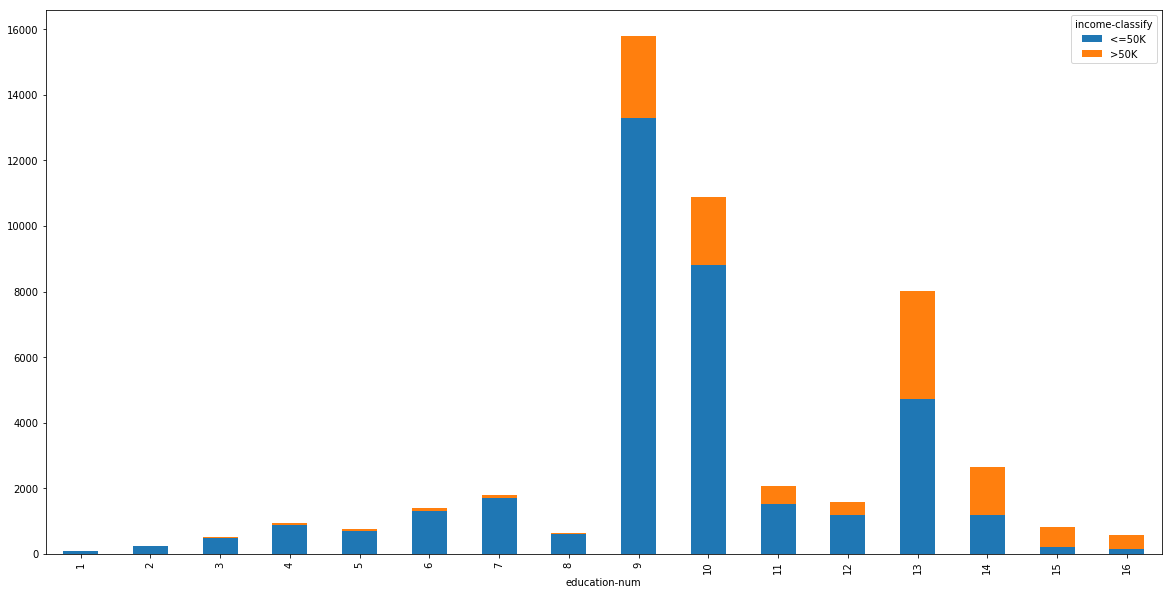

In [14]:
# education vs income
pdf.groupby(['education-num', 'income-classify']).size().unstack().plot(kind='bar', figsize=(20, 10),stacked=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55b2d83ef0>,
      dtype=object)

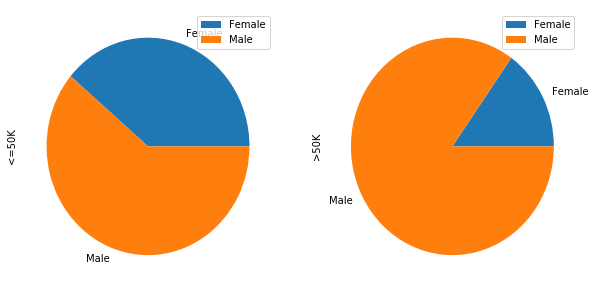

In [15]:
# sex vs income
pdf.groupby(['sex', 'income-classify']).size().unstack().plot(kind='pie', figsize=(10, 5), subplots=True)

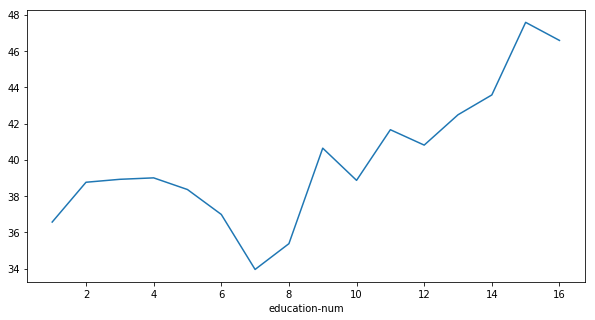

In [16]:
# education num vs avg hours per week
pdf.groupby(['education-num'])['hours-per-week'].mean().plot(kind='line', figsize=(10, 5))

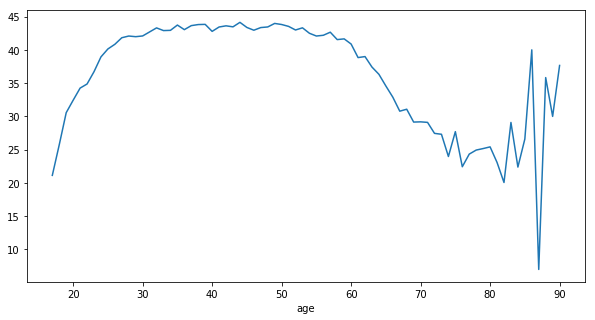

In [17]:
# age vs avg hours per week
pdf.groupby(['age'])['hours-per-week'].mean().plot(kind='line', figsize=(10, 5))

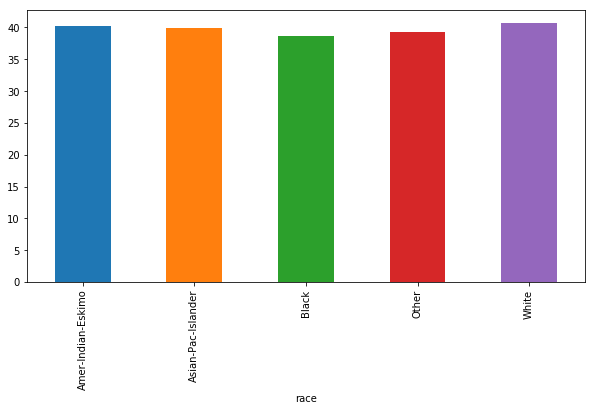

In [18]:
# race vs avg hours per week
pdf.groupby(['race'])['hours-per-week'].mean().plot(kind='bar', figsize=(10, 5))

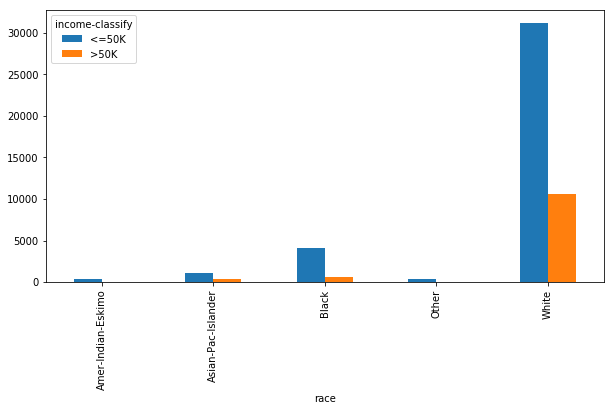

In [19]:
# race vs income
pdf.groupby(['race', 'income-classify']).size().unstack().plot(kind='bar', figsize=(10, 5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55b2326c50>,
      dtype=object)

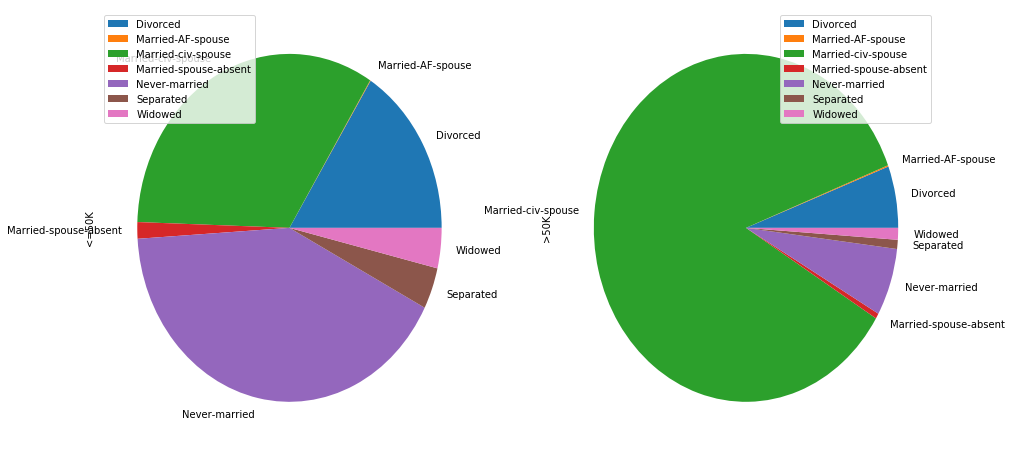

In [20]:
pdf.groupby(['marital-status', 'income-classify']).size().unstack().plot(kind='pie', figsize=(15, 8), subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f55b2179860>,
      dtype=object)

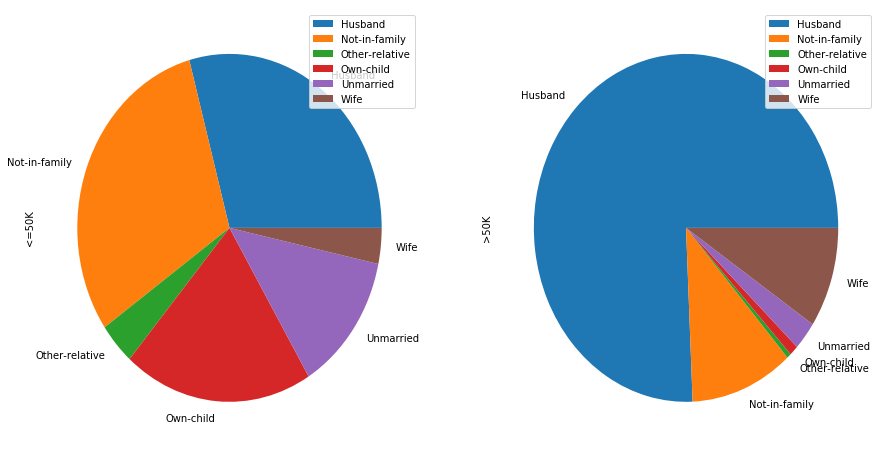

In [21]:
pdf.groupby(['relationship', 'income-classify']).size().unstack().plot(kind='pie', figsize=(15, 8), subplots=True)

# Data preparation

In [22]:
pdfTemp = df.toPandas()

In [23]:
len(pdfTemp)

48842

In [24]:
len(pdf)

48842

##### identify the number of missing values

In [25]:
# missing value
#import numpy as np
#pdfMiss = pdfTemp.replace('?', np.nan)
#len(pdfMiss.dropna())

##### indentify the number of extreme values

In [26]:
# extreme value for age
#extreme = pdfTemp[(pdfTemp['age'] <= 74)]
#len(extreme)

In [27]:
# extreme value for working hours
#extreme = pdfTemp[((pdfTemp['hours-per-week'] >= 8.5) & (pdfTemp['hours-per-week'] <= 72.4))]
#len(extreme)

##### identify the number of duplicated values

In [28]:
# duplicates
#dup = pdfTemp.drop_duplicates()
#len(dup)

#### drop irrelevant features

In [29]:
pdfTemp = pdfTemp.drop(['fnlwgt', 'education'], axis=1)
print("Number of columns:" + str(pdfTemp.columns.size))

Number of columns:13


#### drop instances with missing values, extremes and duplications

In [30]:
import numpy as np
pdfTemp = pdfTemp[((pdfTemp['hours-per-week'] >= 8.5) & (pdfTemp['hours-per-week'] <= 72.4))]
pdfTemp = pdfTemp[(pdfTemp['age'] <= 74)]
pdfTemp = pdfTemp.replace('?', np.nan).dropna()

pdfTemp = pdfTemp.drop_duplicates()

len(pdfTemp)

37928

#### project the data

In [31]:
edu_unm_level = {
    1:'primary',
    2:'primary',
    3:'primary',
    4:'primary',
    5:'secondary',
    6:'secondary',
    7:'secondary',
    8:'secondary',
    9:'secondary',
    10:'undergraduate ',
    11:'undergraduate ',
    12:'undergraduate ',
    13:'undergraduate ',
    14:'higher_than_Master',
    15:'higher_than_Master',
    16:'higher_than_Master'
}

In [32]:
pdfTemp['edu_level'] = pdfTemp['education-num'].map(edu_unm_level)

In [33]:
print(pdfTemp)

       age         workclass  education-num         marital-status  \
0       39         State-gov             13          Never-married   
1       50  Self-emp-not-inc             13     Married-civ-spouse   
2       38           Private              9               Divorced   
3       53           Private              7     Married-civ-spouse   
4       28           Private             13     Married-civ-spouse   
5       37           Private             14     Married-civ-spouse   
6       49           Private              5  Married-spouse-absent   
7       52  Self-emp-not-inc              9     Married-civ-spouse   
8       31           Private             14          Never-married   
9       42           Private             13     Married-civ-spouse   
11      30         State-gov             13     Married-civ-spouse   
12      23           Private             13          Never-married   
13      32           Private             12          Never-married   
15      34          

#### balance the data

In [34]:
print(pd.get_dummies(pdfTemp['income-classify']).sum())

<=50K    28266
>50K      9662
dtype: int64


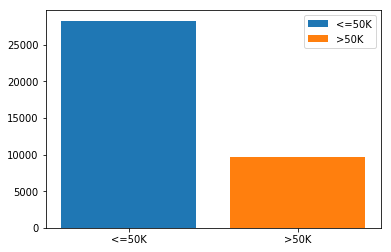

In [35]:
labels = []
for i, dfi in enumerate(pdfTemp.groupby(['income-classify'])):
    labels.append(dfi[0])
    plt.bar(i, dfi[1].count(), label=dfi[0])
plt.xticks(range(len(labels)), labels)
plt.legend()
plt.show()

In [36]:
target_count = pdfTemp['income-classify'].value_counts()
print('Class 1:', target_count[0], ', % =', target_count[0]/target_count.sum())
print('Class 2:', target_count[1], ', % =', target_count[1]/target_count.sum())
print(target_count.sum())

Class 1: 28266 , % = 0.7452541657878085
Class 2: 9662 , % = 0.25474583421219155
37928


Random Under-Sampling:
>50K     9662
<=50K    9662
Name: income-classify, dtype: int64


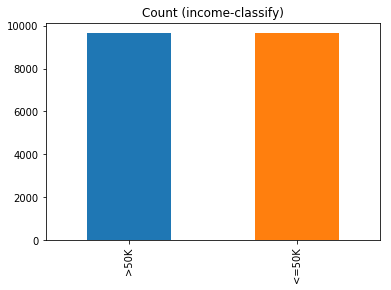

In [37]:
count_class_1, count_class_2 = pdfTemp['income-classify'].value_counts()

# Divide by class
df_class_1 = pdfTemp[pdfTemp['income-classify'] == '<=50K']
df_class_2 = pdfTemp[pdfTemp['income-classify'] == '>50K']


df_class_1_under = df_class_1.sample(count_class_2,replace=True)
df_pd_balanced = pd.concat([df_class_1_under,df_class_2], axis=0)

print('Random Under-Sampling:')
print(df_pd_balanced['income-classify'].value_counts())

df_pd_balanced['income-classify'].value_counts().plot(kind='bar', title='Count (income-classify)');

# Transfer data back to pyspark and prepare for data mining

In [38]:
# transfer from Pandas data frame back to PySpark data frame 
# and prepare for data mining

from pyspark.sql.types import *

mySchema = StructType([ StructField('age', IntegerType(), True)\
                       ,StructField('workclass', StringType(), True)\
                       ,StructField('educationNum', IntegerType(), True)\
                       ,StructField('maritalStatus', StringType(), True)\
                       ,StructField('occupation', StringType(), True)\
                       ,StructField('relationship', StringType(), True)\
                       ,StructField('race', StringType(), True)\
                       ,StructField('sex', StringType(), True)\
                       ,StructField('capitalGain', IntegerType(), True)\
                       ,StructField('capitalLoss', IntegerType(), True)\
                       ,StructField('hoursPerWeek', IntegerType(), True)\
                       ,StructField('nativeCountry', StringType(), True)\
                       ,StructField('incomeClassify', StringType(), True)\
                       ,StructField('eduLevel', StringType(), True)])


In [39]:
df_pyspark = spark.createDataFrame(df_pd_balanced,schema=mySchema)
df_pyspark = df_pyspark.select('age', 'workclass', 'maritalStatus', 'occupation', 'relationship', 'race', 'sex',
                              'capitalGain', 'capitalLoss', 'hoursPerWeek', 'nativeCountry', 'incomeClassify', 'eduLevel')

In [40]:
tempTest = df_pyspark.select('incomeClassify')
tempTest.groupBy('incomeClassify').count().show()

+--------------+-----+
|incomeClassify|count|
+--------------+-----+
|         <=50K| 9662|
|          >50K| 9662|
+--------------+-----+



### one hot encoder and change them into vectors

In [41]:
##iteration 1
# from pyspark.ml import Pipeline
# from pyspark.ml.feature import (OneHotEncoder, StringIndexer, VectorAssembler)
# workclass_indexer = StringIndexer(inputCol='workclass',outputCol='workclassIndex')
# maritalStatus_indexer = StringIndexer(inputCol='maritalStatus',outputCol='maritalStatusIndex')
# occupation_indexer = StringIndexer(inputCol='occupation',outputCol='occupationIndex')
# relationship_indexer = StringIndexer(inputCol='relationship',outputCol='relationshipIndex')
# race_indexer = StringIndexer(inputCol='race',outputCol='raceIndex')
# sex_indexer = StringIndexer(inputCol='sex',outputCol='sexIndex')
# nativeCountry_indexer = StringIndexer(inputCol='nativeCountry',outputCol='nativeCountryIndex')
# eduLevel_indexer = StringIndexer(inputCol='eduLevel',outputCol='eduLevelIndex')
# incomeClassify_indexer = StringIndexer(inputCol='incomeClassify',outputCol='label')

# workclass_encoder = OneHotEncoder(inputCol='workclassIndex',outputCol='workclassVec')
# maritalStatus_encoder = OneHotEncoder(inputCol='maritalStatusIndex',outputCol='maritalStatusVec')
# occupation_encoder = OneHotEncoder(inputCol='occupationIndex',outputCol='occupationVec')
# relationship_encoder = OneHotEncoder(inputCol='relationshipIndex',outputCol='relationshipVec')
# race_encoder = OneHotEncoder(inputCol='raceIndex',outputCol='raceVec')
# sex_encoder = OneHotEncoder(inputCol='sexIndex',outputCol='sexVec')
# nativeCountry_encoder = OneHotEncoder(inputCol='nativeCountryIndex',outputCol='nativeCountryVec')
# eduLevel_encoder = OneHotEncoder(inputCol='eduLevelIndex',outputCol='eduLevelVec')

# assembler = VectorAssembler(inputCols=['workclassVec','maritalStatusVec','occupationVec','relationshipVec',
#                                        'raceVec','sexVec','nativeCountryVec','eduLevelVec',
#                                        'age', 'capitalGain', 'capitalLoss', 'hoursPerWeek',
#                                        ], outputCol="features")


In [42]:
# pipeline = Pipeline(stages=[workclass_indexer, maritalStatus_indexer, occupation_indexer, relationship_indexer,
#                             race_indexer, sex_indexer, nativeCountry_indexer, eduLevel_indexer,
#                             incomeClassify_indexer, workclass_encoder, maritalStatus_encoder, occupation_encoder,
#                             relationship_encoder, race_encoder, sex_encoder, nativeCountry_encoder,
#                             eduLevel_encoder, assembler])


# pipeline_model = pipeline.fit(df_pyspark)
# pipe_df = pipeline_model.transform(df_pyspark)
# pipe_df = pipe_df.select('label', 'features')


In [43]:
# # iteration 2
# change the code more efficiency, clean and robust
from pyspark.ml import Pipeline
from pyspark.ml.feature import (OneHotEncoder, StringIndexer, VectorAssembler)

categoricalColumns = ['workclass', 'maritalStatus', 'occupation', 'relationship', 'race', 'sex', 'nativeCountry', 'eduLevel']
temp = []


for col in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Indexer')
    encoder = OneHotEncoder(inputCol = stringIndexer.getOutputCol(), outputCol = col + 'Vec')
    temp += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'incomeClassify', outputCol = 'label')
temp += [label_stringIdx]

numericCols = ['age', 'capitalGain', 'capitalLoss', 'hoursPerWeek']
assemblerInputs = [c + "Vec" for c in categoricalColumns] + numericCols

assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features')
temp += [assembler]

pipeline = Pipeline(stages = temp)
pipeline_model = pipeline.fit(df_pyspark)
pipe_df = pipeline_model.transform(df_pyspark)
pipe_df = pipe_df.select('label', 'features')

# col = df_pyspark.columns
# selectedcols = ["label", "features"] + col
# pipe_df.select(selectedcols).show(10)

### split dataset into training and test set

In [44]:
# split the data into 0.8 and 0.2
train_data, test_data = pipe_df.randomSplit([0.8,0.2])

# print the number of each data
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))


Training Dataset Count: 15458
Test Dataset Count: 3866


# Data mining

### Logistic Regression

In [45]:
#############################################
###########  LOGISTIC REGRESSION  ###########
#############################################

from pyspark.ml.classification import LogisticRegression

# Instantiate the LR model.
# iteration 1
#lr_model = LogisticRegression(featuresCol='features',labelCol='label')

#iteration 2
lr = LogisticRegression(featuresCol='features',labelCol='label', maxIter = 10)

## print the LR model descriptions
## print(lr_model.explainParams())

# Fit set into the model.
lr_model = lr.fit(train_data)
# print(lr_model.numFeatures)

# And evaluate the model using the test data.
lr_result = lr_model.transform(test_data)
from pyspark.ml.evaluation import BinaryClassificationEvaluator

lr_evaluator = BinaryClassificationEvaluator()
lr_evaluator.evaluate(lr_result)
# print(evaluator.getLabelCol())
# print(results.show(3))
print("Test Area Under ROC: " + str(lr_evaluator.evaluate(lr_result, {lr_evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8948178553104301


#### This is result without tuning the parameters

In [46]:
# tp = results[(results.label == 1) & (results.prediction == 1)].count()
# tn = results[(results.label == 0) & (results.prediction == 0)].count()
# fp = results[(results.label == 0) & (results.prediction == 1)].count()
# fn = results[(results.label == 1) & (results.prediction == 0)].count()

# metrics=spark.createDataFrame([
#         ('Yes', tp, fp),
#         ('No',fn, tn)], ['', 'Positive', 'Negative'])
#         # ("Percision",tp/(tp+fp)),
#         # ("Recall",tp/(tp+fn)) ])
# metrics.show()

# print("Percision: ", tp / (tp + fp))
# print("Recall: ", tp / (tp + fn))
# print("Accuracy: ", (tp + tn) / (tp + tn + fn + fp))
# print("F1 Score: ", (2 * tp) / (2 * tp + fn + fp))

###################################
###################################
# +---+--------+--------+
# |   |Positive|Negative|
# +---+--------+--------+
# |Yes|    1613|     430|
# | No|     329|    1529|
# +---+--------+--------+

# Percision:  0.7895252080274107
# Recall:  0.8305870236869207
# Accuracy:  0.8054345039733402
# F1 Score:  0.8095357590966124

#### tuning the parameter

In [47]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.maxIter, [10, 15, 20])
             .build())


In [48]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=lr_evaluator, numFolds=3)

# Run cross validations
cvModel = cv.fit(train_data)
predictions = cvModel.transform(test_data)
print('The Area Under ROC', lr_evaluator.evaluate(predictions))

The Area Under ROC 0.8994263274216053


#### This is the result with tuning the parameters

In [49]:
lrtp = lr_result[(lr_result.label == 1) & (lr_result.prediction == 1)].count()
lrtn = lr_result[(lr_result.label == 0) & (lr_result.prediction == 0)].count()
lrfp = lr_result[(lr_result.label == 0) & (lr_result.prediction == 1)].count()
lrfn = lr_result[(lr_result.label == 1) & (lr_result.prediction == 0)].count()


In [50]:
lr_metrics = spark.createDataFrame([
        ('Yes', lrtp, lrfp),
        ('No',lrfn, lrtn)], ['', 'Positive', 'Negative'])
        # ("Percision",tp/(tp+fp)),
        # ("Recall",tp/(tp+fn)) ])
lr_metrics.show()

print("Percision: ", lrtp / (lrtp + lrfp))
print("Recall: ", lrtp / (lrtp + lrfn))
print("Accuracy: ", (lrtp + lrtn) / (lrtp + lrtn + lrfn + lrfp))
print("F1 Score: ", (2 * lrtp) / (2 * lrtp + lrfn + lrfp))

lr_result.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


###################################################
###################################################
# +---+--------+--------+
# |   |Positive|Negative|
# +---+--------+--------+
# |Yes|    1567|     411|
# | No|     352|    1513|
# +---+--------+--------+

# Percision:  0.7922143579373104
# Recall:  0.8165711307972903
# Accuracy:  0.8014571948998178
# F1 Score:  0.8042083654092892
# +-----+--------------------+----------+--------------------+
# |label|       rawPrediction|prediction|         probability|
# +-----+--------------------+----------+--------------------+
# |  0.0|[-2.0814475874900...|       1.0|[0.11091313764108...|
# |  0.0|[-1.0566277943392...|       1.0|[0.25795441480604...|
# |  0.0|[-1.2947212999891...|       1.0|[0.21505475392738...|
# |  0.0|[-1.0942670953406...|       1.0|[0.25081560845973...|
# |  0.0|[-0.9846301677660...|       1.0|[0.27197402387667...|
# |  0.0|[-1.2227236734159...|       1.0|[0.22745748985590...|
# |  0.0|[-2.3079743992768...|       1.0|[0.09046467458317...|
# |  0.0|[-2.3079743992768...|       1.0|[0.09046467458317...|
# |  0.0|[-1.4164794533653...|       1.0|[0.19521408758380...|
# |  0.0|[-2.4352918275955...|       1.0|[0.08052080437273...|
# +-----+--------------------+----------+--------------------+
# only showing top 10 rows



+---+--------+--------+
|   |Positive|Negative|
+---+--------+--------+
|Yes|    1605|     417|
| No|     330|    1532|
+---+--------+--------+

Percision:  0.7937685459940653
Recall:  0.8294573643410853
Accuracy:  0.8076725025746653
F1 Score:  0.8112206216830933
+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[-2.6267740299354...|       1.0|[0.06743504108306...|
|  0.0|[-2.8796301222649...|       1.0|[0.05316975397628...|
|  0.0|[-2.6117432789292...|       1.0|[0.06838645625980...|
|  0.0|[-2.6117432789292...|       1.0|[0.06838645625980...|
|  0.0|[-0.7828892692927...|       1.0|[0.31369751670009...|
|  0.0|[-1.2700296632910...|       1.0|[0.21925217426389...|
|  0.0|[-1.5737546090015...|       1.0|[0.17168180108454...|
|  0.0|[-1.3273446688191...|       1.0|[0.20959892733052...|
|  0.0|[-1.2127518107532...|       1.0|[0.22921451194693...|
|  0

#### visualized the model

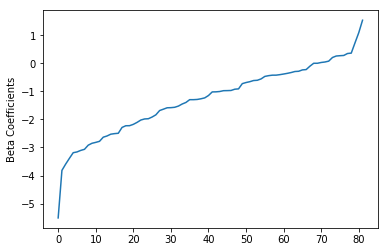

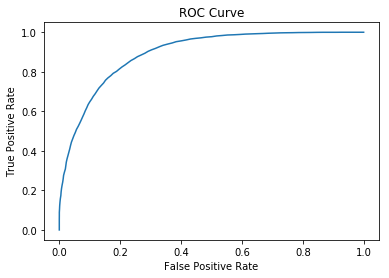

Area Under the Curve: 0.8942539786042067


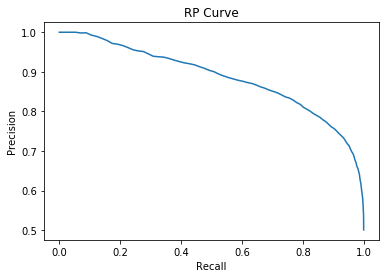

In [51]:
from pyspark.ml.classification import BinaryLogisticRegressionTrainingSummary
import numpy as np
# get a summary of the data.
training_summary = lr_model.summary

# Convert to the Pandas DataFrame.
ROC = training_summary.roc.toPandas()

beta = np.sort(lr_model.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Plot the true positive and false positive rates.
plt.plot(ROC['FPR'],ROC['TPR'])

# Define the labels.
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print the AUC statistic. 
print('Area Under the Curve: ' + str(training_summary.areaUnderROC))

# Convert to the Pandas DataFrame.
pr = training_summary.pr.toPandas()

# Plot model recall and precision.
plt.plot(pr['recall'],pr['precision'])

# Define the labels and show the graph. 
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('RP Curve')
plt.show()


### Decision Tree

In [45]:
#############################################
###########     DECISION TREE     ###########
#############################################

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

##print the DT model descriptions
##print(dt_model.explainParams())

dt_model = dt.fit(train_data)
dt_result = dt_model.transform(test_data)

## print(dt_model.toDebugString)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

dt_evaluator = BinaryClassificationEvaluator()
dt_evaluator.evaluate(dt_result)
print("Test Area Under ROC: " + str(dt_evaluator.evaluate(dt_result, {dt_evaluator.metricName: "areaUnderROC"})))


Test Area Under ROC: 0.735418369425372


In [46]:
dttp = dt_result[(dt_result.label == 1) & (dt_result.prediction == 1)].count()
dttn = dt_result[(dt_result.label == 0) & (dt_result.prediction == 0)].count()
dtfp = dt_result[(dt_result.label == 0) & (dt_result.prediction == 1)].count()
dtfn = dt_result[(dt_result.label == 1) & (dt_result.prediction == 0)].count()


In [47]:
dt_metrics = spark.createDataFrame([
        ('Yes', dttp, dtfp),
        ('No',dtfn, dttn)], ['', 'Positive', 'Negative'])
        # ("Percision",tp/(tp+fp)),
        # ("Recall",tp/(tp+fn)) ])
dt_metrics.show()

print("Percision: ", dttp / (dttp + dtfp))
print("Recall: ", dttp / (dttp + dtfn))
print("Accuracy: ", (dttp + dttn) / (dttp + dttn + dtfn + dtfp))
print("F1 Score: ", (2 * dttp) / (2 * dttp + dtfn + dtfp))

dt_result.select('label', 'rawPrediction', 'prediction', 'probability').show(10)





###################################################
###################################################

# +---+--------+--------+
# |   |Positive|Negative|
# +---+--------+--------+
# |Yes|    1782|     720|
# | No|     166|    1251|
# +---+--------+--------+

# Percision:  0.7122302158273381
# Recall:  0.9147843942505134
# Accuracy:  0.7739219188568512
# F1 Score:  0.8008988764044944
# +-----+---------------+----------+--------------------+
# |label|  rawPrediction|prediction|         probability|
# +-----+---------------+----------+--------------------+
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1229.0,3987.0]|       1.0|[0.23562116564417...|
# |  0.0|[1233.0,1359.0]|       1.0|[0.47569444444444...|
# +-----+---------------+----------+--------------------+
# only showing top 10 rows

+---+--------+--------+
|   |Positive|Negative|
+---+--------+--------+
|Yes|    1826|     687|
| No|     164|    1262|
+---+--------+--------+

Percision:  0.7266215678471946
Recall:  0.9175879396984925
Accuracy:  0.783955318608784
F1 Score:  0.8110148789695758
+-----+---------------+----------+--------------------+
|label|  rawPrediction|prediction|         probability|
+-----+---------------+----------+--------------------+
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
|  0.0|[1356.0,3925.0]|       1.0|[0.25676955122135...|
+-----+--

### Random Forest

In [45]:
#############################################
###########     RANDOM FOREST     ###########
#############################################


from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
# print the RF model descriptions
# print(rf_model.explainParams())

rf_model = rf.fit(train_data)
rf_result = rf_model.transform(test_data)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf_evaluator = BinaryClassificationEvaluator()
rf_evaluator.evaluate(rf_result)
print("Test Area Under ROC: " + str(rf_evaluator.evaluate(rf_result, {rf_evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8840869349660885


In [46]:
rftp = rf_result[(rf_result.label == 1) & (rf_result.prediction == 1)].count()
rftn = rf_result[(rf_result.label == 0) & (rf_result.prediction == 0)].count()
rffp = rf_result[(rf_result.label == 0) & (rf_result.prediction == 1)].count()
rffn = rf_result[(rf_result.label == 1) & (rf_result.prediction == 0)].count()

In [47]:
rf_metrics=spark.createDataFrame([
        ('Yes', rftp, rffp),
        ('No',rffn, rftn)], ['', 'Positive', 'Negative'])
        # ("Percision",tp/(tp+fp)),
        # ("Recall",tp/(tp+fn)) ])
rf_metrics.show()

print("Percision: ", rftp / (rftp + rffp))
print("Recall: ", rftp / (rftp + rffn))
print("Accuracy: ", (rftp + rftn) / (rftp + rftn + rffn + rffp))
print("F1 Score: ", (2 * rftp) / (2 * rftp + rffn + rffp))

rf_result.select('label', 'rawPrediction', 'prediction', 'probability').show(10)



###################################################
###################################################
# +---+--------+--------+
# |   |Positive|Negative|
# +---+--------+--------+
# |Yes|    1735|     608|
# | No|     241|    1291|
# +---+--------+--------+

# Percision:  0.7405036278275715
# Recall:  0.8780364372469636
# Accuracy:  0.7809032258064517
# F1 Score:  0.8034267191479509
# +-----+--------------------+----------+--------------------+
# |label|       rawPrediction|prediction|         probability|
# +-----+--------------------+----------+--------------------+
# |  0.0|[5.74444730520521...|       1.0|[0.28722236526026...|
# |  0.0|[5.74444730520521...|       1.0|[0.28722236526026...|
# |  0.0|[5.78945726584193...|       1.0|[0.28947286329209...|
# |  0.0|[5.78945726584193...|       1.0|[0.28947286329209...|
# |  0.0|[5.78945726584193...|       1.0|[0.28947286329209...|
# |  0.0|[6.96912836401035...|       1.0|[0.34845641820051...|
# |  0.0|[6.96912836401035...|       1.0|[0.34845641820051...|
# |  0.0|[6.96912836401035...|       1.0|[0.34845641820051...|
# |  0.0|[6.96912836401035...|       1.0|[0.34845641820051...|
# |  0.0|[6.73755967906444...|       1.0|[0.33687798395322...|
# +-----+--------------------+----------+--------------------+
# only showing top 10 rows

+---+--------+--------+
|   |Positive|Negative|
+---+--------+--------+
|Yes|    1657|     532|
| No|     245|    1432|
+---+--------+--------+

Percision:  0.7569666514390132
Recall:  0.8711882229232387
Accuracy:  0.7990170719089498
F1 Score:  0.8100708873136152
+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[6.62456329165463...|       1.0|[0.33122816458273...|
|  0.0|[4.69854504517582...|       1.0|[0.23492725225879...|
|  0.0|[5.50006774649997...|       1.0|[0.27500338732499...|
|  0.0|[5.50006774649997...|       1.0|[0.27500338732499...|
|  0.0|[5.50006774649997...|       1.0|[0.27500338732499...|
|  0.0|[5.21944724295913...|       1.0|[0.26097236214795...|
|  0.0|[5.21944724295913...|       1.0|[0.26097236214795...|
|  0.0|[5.50006774649997...|       1.0|[0.27500338732499...|
|  0.0|[6.62456329165463...|       1.0|[0.33122816458273...|
|  0